In [1]:
import cwms
from datetime import datetime, timedelta
import json
import pandas as pd
import xml.etree.ElementTree as ET


In [2]:
# load .env python environment for storing API_KEY
# .env file can be stored a parent directory of script
# https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1
from dotenv import load_dotenv
import os

In [3]:
def create_ts_id(nws_id, usace_parameterId):
    'create the TS id for the NWS location and USACE parameter'
    cwms_loc = nws_alias[nws_alias['NWS_ID']== nws_id].index[0]
    interval = '6Hours'
    duration = '0'
    d_type = 'Inst'
    version = CWMS_Ver
    if 'Precip' in usace_parameterId:
        d_type = 'Total'
        duration = '6Hours'
    ts_id  = f'{cwms_loc}.{usace_parameterId}.{d_type}.{interval}.{duration}.{version}'
    return cwms_loc, ts_id

def parse_nws_loc_parm_data(locId, param):
    'Parse the NWS parameter data that may be embedded in the NWS loc'
    param_mod = None
    if locId == 'BoundaryDiversion':
        nws_id = locId
    else:
        nws_id = locId[:5]
    if ('IN' in locId[5::]) & ("Flow" in param):
        param = 'Flow-In'

    if ('OUT' in locId[5::]) & ("Flow" in param):
        param = 'Flow-Out'

    if ('LOC' in locId[5::])  & ("Flow" in param):
        param = 'Flow-Local'


    if ('NON' in locId) & (len(locId) > 5):
        param = param +'-Non_contrib'

    return nws_id, param

def load_chps_data(file_path):
    cwms_missing_value = -340282346638528859811704183484516925440
    cwms_missing_quality = 5
    # Define the namespace
    ns = {'pi': 'http://www.wldelft.nl/fews/PI'}
    
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    
    # Iterate over series elements
    for series in root.findall('pi:series', ns):
        header = series.find('pi:header', ns)
        nws_locationId = header.find('pi:locationId', ns).text
        nws_parameterId = header.find('pi:parameterId', ns).text
        nws_units = header.find('pi:units', ns).text
        nws_missing = header.find('pi:missVal', ns).text
        try:
            usace_parameterId = param_mapping_dict[nws_parameterId]
        except:
            print(f'*****Unknown parameter {nws_locationId} {nws_parameterId} - skipping')
        try:
            nws_creationDate = header.find('pi:creationDate', ns).text
            nws_creationTime = header.find('pi:creationTime', ns).text
        except:
            nws_creationDate = None
            nws_creationTime = None

        nws_id, usace_parameterId = parse_nws_loc_parm_data(nws_locationId, usace_parameterId)
        
        #print(f"Location ID: {nws_id}")
        try:
            cwms_loc, ts_id = create_ts_id(nws_id, usace_parameterId)
            
            
            # Iterate over event elements
            dt_col = []
            val_col = []
            quality_col = []
            for event in series.findall('pi:event', ns):
                date_string = event.get('date')
                time_string = event.get('time')
                datetime_string = f"{date_string} {time_string}"
                dt_object = datetime.strptime(datetime_string, '%Y-%m-%d %H:%M:%S')
                value = event.get('value')
                if value == nws_missing:
                    value = cwms_missing_value
                    quality_code = cwms_missing_quality
                else:
                    quality_code = 0
                dt_col.append(dt_object)
                val_col.append(value)
                quality_col.append(quality_code)
                #print(f"Event - Date: {date}, Time: {time}, Value: {value}")
            df = pd.DataFrame({'date-time': dt_col, 'value': val_col, 'quality-code':quality_col} )
            df["date-time"] = pd.to_datetime(df["date-time"])
            if versionDateTime:
                data_json = cwms.timeseries_df_to_json(data = df, 
                                                   ts_id = ts_id, units = nws_units, office_id = OFFICE, version_date= versionDateTime)
            else:
                data_json = cwms.timeseries_df_to_json(data = df, 
                                                   ts_id = ts_id, units = nws_units, office_id = OFFICE)
            #print(f'Storing {nws_locationId} {nws_parameterId} as {ts_id} with {nws_units} units and version {versionDateTime}')
            #cwms.store_timeseries(data=data_json)
            #print(ts_id, nws_id, nws_locationId, nws_parameterId, usace_parameterId, nws_units, nws_creationDate, nws_creationTime, versionDateTime)
        
        except:
            print(f'***CWMS location not found for {nws_id}....skipping')

    return data_json

In [4]:
# grab API variables from .env file
load_dotenv()
APIROOT = os.getenv("API_ROOT")
OFFICE = os.getenv("OFFICE")
APIKEY = os.getenv('API_KEY')
#APIROOT

In [5]:
# api key needs to have the test "apikey" as a prefix to work with CDA 
apiKey = "apikey " + APIKEY

In [6]:
api = cwms.api.init_session(api_root = APIROOT, api_key = apiKey)
#defined apiroot
#cwms.api.return_base_url()


In [3]:
# nws parameter mapping to USACE paramater
param_mapping_dict = {
    'SQIN': 'Flow-Sim',
    'SPEL': 'Elev',
    'QINE': 'Flow',
    'RAIM': 'Precip-RainAndMelt',
    'MAP': 'Precip-Rain',
    'SSTG': 'Stage'
}
#missing value in CWMS
cwms_missing_value = -340282346638528859811704183484516925440
cwms_missing_quality = 5
# base version part in CWMS
CWMS_Ver_Base = "Fcst-NCRFC-CHIPS"  


In [8]:
# get cwms location group to link NWS station ID
Locdf = cwms.get_location_group(loc_group_id  = "NWS Handbook 5 ID",category_id= "Agency Aliases", office_id = "CWMS").df.set_index('location-id')
Locdf

,office-id,alias-id,attribute
location-id,,,
Winter,MVP,WERW3,0.0
Breckenridge-Doran,MVP,DRSM5,0.0
StBenedict,MVP,STBN8,0.0
Baker,MVP,BKRM5,0.0
Georgetown,MVP,BRGM5,0.0
...,...,...,...
Hokah,MVP,HKHM5,NaN
Kloten,MVP,MVCN8,NaN
Grafton-Diversion,MVP,GFBN8,NaN


In [9]:
#Grab all of the locations that have a nws station number assigned to them
nws_alias=Locdf[Locdf['alias-id'].notnull()]

#rename the columns
nws_alias = nws_alias.rename(columns = {'alias-id': 'NWS_ID','attribute':'Loc_attribute'})
nws_alias




,office-id,NWS_ID,Loc_attribute
location-id,,,
Winter,MVP,WERW3,0.0
Breckenridge-Doran,MVP,DRSM5,0.0
StBenedict,MVP,STBN8,0.0
Baker,MVP,BKRM5,0.0
Georgetown,MVP,BRGM5,0.0
...,...,...,...
Hokah,MVP,HKHM5,NaN
Kloten,MVP,MVCN8,NaN
Grafton-Diversion,MVP,GFBN8,NaN


# Set up RFC CHPS Aliases group to map NWS ID's in the CHPs system that may not map exactly to your NWS HB 5 Id's
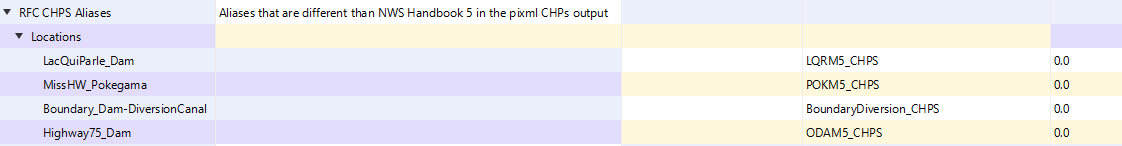

use the suffix _CHPS so that duplicate NWS aliases can be used in the NWS HB 5 table and the RFC CHPS Alias table

In [10]:
# grab the location group of RFC CHPS Aliases
tmp_df = cwms.get_location_group(loc_group_id  = "Locations",category_id= "RFC CHPS Aliases", office_id = "MVP").df.set_index('location-id')
#Grab all of the locations that have a eccc station number assigned to them
tmp_df=tmp_df[tmp_df['alias-id'].notnull()]

#rename the columns
tmp_df = tmp_df.rename(columns = {'alias-id': 'NWS_ID','attribute':'Loc_attribute'})

# drop the _CHPS suffix
tmp_df['NWS_ID'] = tmp_df['NWS_ID'].str.slice(0, -5)
nws_alias.update(tmp_df)

# find duplicates
duplicates = nws_alias[nws_alias['NWS_ID'].duplicated(keep=False)]

#drop duplicates that are sublocations
rows_to_drop = duplicates.index[duplicates.index.str.contains('-')]


nws_alias = nws_alias.drop(rows_to_drop)


In [13]:
directory = './chps_dir'
onlyfiles = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename)) and 'scour' not in filename]

# walk through files
for filename in onlyfiles:
    #print('%s being processed' %(filename))
    Filetime = filename.split(".")[1]
    fmt = '%Y%m%d%H%M%S' 
    fDateTime = datetime.strptime(Filetime, fmt)
    if 'auto' in filename:
        fileBaseName = filename.split('MSR_main_auto_')[1].split('.')[0]
        versionDateTime = textKey = None
        CWMS_Ver = CWMS_Ver_Base+"-Auto"
        textKey = 'cva_'+fileBaseName[0:12]
    elif 'CRF' in filename:
        fileBaseName = filename.split('MSR_CRF_')[1].split('.')[0]
        versionDateTime = textKey = None
        CWMS_Ver = CWMS_Ver_Base+"-CRF"
        textKey = 'cvc_'+fileBaseName[0:12]
    else:
        fileBaseName = filename.split('MSR_main_')[1].split('.')[0]
        # set version datetime to current date and 0111 time to avoid too many versions
        versionDateTime = fDateTime.replace(hour=1, minute=11, second=0)
        versionDateTime = versionDateTime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + "Z"
        #versionDate = fDateTime.strftime(f'%d%b%Y, {versionTime}')
        # standard text id to save last runtime to
        textKey = 'cv_'+fileBaseName[0:12]
        CWMS_Ver = CWMS_Ver_Base

    print(textKey, fileBaseName, filename, fDateTime)
    # format CHPS data
    fullPath = os.path.join(directory, filename)
    # parse chps and put into a json dictionary for cwms-python store
    data_json = load_chps_data(fullPath)

    
    # store file date under standard text id key
    print(f'***Storing run time {fDateTime} under {textKey} for file {filename}')
    msg = cwms.standard_text_to_json(text_id = textKey, standard_text =fDateTime, office_id = OFFICE)
    cwms.store_standard_text(msg)
    #textStore = cwms.get_standard_text(text_id = textKey, office_id = 'MVP')


        

cv_wis_wisconsi wis_wisconsin_river MSR_2024080812_MSR_main_wis_wisconsin_river.20240808133945 2024-08-08 13:39:45
***CWMS location not found for RBGW3....skipping
***Storing run time 2024-08-08 13:39:45 under cv_wis_wisconsi for file MSR_2024080812_MSR_main_wis_wisconsin_river.20240808133945
cv_rdw rdw MSR_2024080912_MSR_main_rdw.20240809143655 2024-08-09 14:36:55
***CWMS location not found for MCAM5....skipping
***CWMS location not found for MCAM5....skipping
***CWMS location not found for PRNM5....skipping
***CWMS location not found for GTBM5....skipping
***CWMS location not found for GTBM5....skipping
***CWMS location not found for MCAM5....skipping
***CWMS location not found for PRNM5....skipping
***Storing run time 2024-08-09 14:36:55 under cv_rdw for file MSR_2024080912_MSR_main_rdw.20240809143655
cva_chp chp MSR_2024081212_MSR_main_auto_chp.20240812122155 2024-08-12 12:21:55
***CWMS location not found for HOLIN....skipping
***CWMS location not found for LEPW3....skipping
***CWM